In [1]:
pip install kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ResNetModel, ViTModel
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
# Load & freeze ResNet-50
cnn = ResNetModel.from_pretrained("microsoft/resnet-50")
for p in cnn.parameters():
    p.requires_grad = False

# Load & freeze DINO-ViT, with safetensors
vit = ViTModel.from_pretrained("facebook/dino-vitb16", use_safetensors=True)
for p in vit.parameters():
    p.requires_grad = False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
class CNNtoViT(nn.Module):
    def __init__(self, cnn, vit):
        super().__init__()
        self.cnn = cnn
        self.vit = vit
        self.project = nn.Linear(2048, 768)

    def forward(self, x):
       # [B, 2048, 7, 7]
        cnn_out = self.cnn(x).last_hidden_state
        b, c, h, w = cnn_out.shape
         # [B, 49, 2048]
        cnn_flat = cnn_out.view(b, c, h * w).permute(0, 2, 1)
        # [B, 49, 768]
        projected = self.project(cnn_flat)

        cls_token = self.vit.embeddings.cls_token.expand(b, -1, -1)
         # [B, 50, 768]
        x = torch.cat((cls_token, projected), dim=1)
        x = x + self.vit.embeddings.position_embeddings[:, :x.size(1), :]
        x = self.vit.embeddings.dropout(x)
        x = self.vit.encoder(x)
         # CLS token
        return x.last_hidden_state[:, 0, :]

In [6]:
class FullModel(nn.Module):
    def __init__(self, cnn, vit, num_classes=7):
        super().__init__()
        self.backbone = CNNtoViT(cnn, vit)
        self.classifier = nn.Sequential(
                    nn.Linear(768, 256),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(256, num_classes)
                )


    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

model = FullModel(cnn, vit)

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


# training data
full_train_data = datasets.ImageFolder("/kaggle/input/fer2013/train", transform=transform)

# split 90% train, 10% val
train_size = int(0.9 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_data, val_data = random_split(full_train_data, [train_size, val_size])

test_data = datasets.ImageFolder("/kaggle/input/fer2013/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 25
best_val_accuracy = 0.0
save_path = "saved_emotion_model"
os.makedirs(save_path, exist_ok=True)

# training loop
for epoch in range(num_epochs):

    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # val
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # train, val loss + accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val

    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step(avg_val_loss)
    # current lr
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.6f}")

    # save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), os.path.join(save_path, "best_model.bin"))
        print(f"New best model saved at epoch {epoch+1} with Val Acc: {val_accuracy:.2f}%")

Epoch 1 - Training: 100%|██████████| 808/808 [04:51<00:00,  2.78it/s]


Epoch 1 | Train Loss: 1.8194 | Train Acc: 24.68% | Val Loss: 1.8096 | Val Acc: 24.10%
Learning Rate: 0.000100
New best model saved at epoch 1 with Val Acc: 24.10%


Epoch 2 - Training: 100%|██████████| 808/808 [04:50<00:00,  2.78it/s]


Epoch 2 | Train Loss: 1.8094 | Train Acc: 25.21% | Val Loss: 1.8062 | Val Acc: 24.56%
Learning Rate: 0.000100
New best model saved at epoch 2 with Val Acc: 24.56%


Epoch 3 - Training: 100%|██████████| 808/808 [04:45<00:00,  2.83it/s]


Epoch 3 | Train Loss: 1.8024 | Train Acc: 25.18% | Val Loss: 1.8057 | Val Acc: 24.10%
Learning Rate: 0.000100


Epoch 4 - Training: 100%|██████████| 808/808 [04:44<00:00,  2.84it/s]


Epoch 4 | Train Loss: 1.7969 | Train Acc: 25.45% | Val Loss: 1.7911 | Val Acc: 24.49%
Learning Rate: 0.000100


Epoch 5 - Training: 100%|██████████| 808/808 [04:44<00:00,  2.84it/s]


Epoch 5 | Train Loss: 1.7922 | Train Acc: 25.82% | Val Loss: 1.7903 | Val Acc: 24.80%
Learning Rate: 0.000100
New best model saved at epoch 5 with Val Acc: 24.80%


Epoch 6 - Training: 100%|██████████| 808/808 [04:43<00:00,  2.85it/s]


Epoch 6 | Train Loss: 1.7856 | Train Acc: 25.70% | Val Loss: 1.7871 | Val Acc: 24.83%
Learning Rate: 0.000100
New best model saved at epoch 6 with Val Acc: 24.83%


Epoch 7 - Training: 100%|██████████| 808/808 [04:45<00:00,  2.83it/s]


Epoch 7 | Train Loss: 1.7801 | Train Acc: 25.81% | Val Loss: 1.7804 | Val Acc: 24.80%
Learning Rate: 0.000100


Epoch 8 - Training: 100%|██████████| 808/808 [04:49<00:00,  2.79it/s]


Epoch 8 | Train Loss: 1.7770 | Train Acc: 26.19% | Val Loss: 1.7733 | Val Acc: 25.88%
Learning Rate: 0.000100
New best model saved at epoch 8 with Val Acc: 25.88%


Epoch 9 - Training: 100%|██████████| 808/808 [04:44<00:00,  2.84it/s]


Epoch 9 | Train Loss: 1.7706 | Train Acc: 26.72% | Val Loss: 1.7656 | Val Acc: 27.17%
Learning Rate: 0.000100
New best model saved at epoch 9 with Val Acc: 27.17%


Epoch 10 - Training: 100%|██████████| 808/808 [04:47<00:00,  2.81it/s]


Epoch 10 | Train Loss: 1.7648 | Train Acc: 26.77% | Val Loss: 1.7623 | Val Acc: 26.54%
Learning Rate: 0.000100


Epoch 11 - Training: 100%|██████████| 808/808 [04:44<00:00,  2.84it/s]


Epoch 11 | Train Loss: 1.7607 | Train Acc: 27.27% | Val Loss: 1.7609 | Val Acc: 26.23%
Learning Rate: 0.000100


Epoch 12 - Training: 100%|██████████| 808/808 [04:43<00:00,  2.85it/s]


Epoch 12 | Train Loss: 1.7556 | Train Acc: 27.67% | Val Loss: 1.7599 | Val Acc: 25.98%
Learning Rate: 0.000100


Epoch 13 - Training: 100%|██████████| 808/808 [04:41<00:00,  2.87it/s]


Epoch 13 | Train Loss: 1.7546 | Train Acc: 27.69% | Val Loss: 1.7480 | Val Acc: 26.79%
Learning Rate: 0.000100


Epoch 14 - Training: 100%|██████████| 808/808 [04:42<00:00,  2.86it/s]


Epoch 14 | Train Loss: 1.7502 | Train Acc: 27.95% | Val Loss: 1.7457 | Val Acc: 27.73%
Learning Rate: 0.000100
New best model saved at epoch 14 with Val Acc: 27.73%


Epoch 15 - Training: 100%|██████████| 808/808 [04:44<00:00,  2.84it/s]


Epoch 15 | Train Loss: 1.7452 | Train Acc: 28.38% | Val Loss: 1.7472 | Val Acc: 28.00%
Learning Rate: 0.000100
New best model saved at epoch 15 with Val Acc: 28.00%


Epoch 16 - Training: 100%|██████████| 808/808 [04:43<00:00,  2.85it/s]


Epoch 16 | Train Loss: 1.7465 | Train Acc: 28.62% | Val Loss: 1.7442 | Val Acc: 29.40%
Learning Rate: 0.000100
New best model saved at epoch 16 with Val Acc: 29.40%


Epoch 17 - Training: 100%|██████████| 808/808 [04:43<00:00,  2.85it/s]


Epoch 17 | Train Loss: 1.7418 | Train Acc: 28.71% | Val Loss: 1.7412 | Val Acc: 28.07%
Learning Rate: 0.000100


Epoch 18 - Training: 100%|██████████| 808/808 [04:43<00:00,  2.85it/s]


Epoch 18 | Train Loss: 1.7425 | Train Acc: 28.67% | Val Loss: 1.7411 | Val Acc: 27.69%
Learning Rate: 0.000100


Epoch 19 - Training: 100%|██████████| 808/808 [04:43<00:00,  2.85it/s]


Epoch 19 | Train Loss: 1.7400 | Train Acc: 29.04% | Val Loss: 1.7485 | Val Acc: 27.45%
Learning Rate: 0.000100


Epoch 20 - Training: 100%|██████████| 808/808 [04:43<00:00,  2.85it/s]


Epoch 20 | Train Loss: 1.7363 | Train Acc: 29.03% | Val Loss: 1.7412 | Val Acc: 28.67%
Learning Rate: 0.000100


Epoch 21 - Training: 100%|██████████| 808/808 [04:43<00:00,  2.85it/s]


Epoch 21 | Train Loss: 1.7334 | Train Acc: 29.07% | Val Loss: 1.7379 | Val Acc: 28.14%
Learning Rate: 0.000100


Epoch 22 - Training: 100%|██████████| 808/808 [04:44<00:00,  2.84it/s]


Epoch 22 | Train Loss: 1.7328 | Train Acc: 29.40% | Val Loss: 1.7246 | Val Acc: 30.23%
Learning Rate: 0.000100
New best model saved at epoch 22 with Val Acc: 30.23%


Epoch 23 - Training: 100%|██████████| 808/808 [04:47<00:00,  2.81it/s]


Epoch 23 | Train Loss: 1.7310 | Train Acc: 29.54% | Val Loss: 1.7242 | Val Acc: 29.15%
Learning Rate: 0.000100


Epoch 24 - Training: 100%|██████████| 808/808 [04:42<00:00,  2.86it/s]


Epoch 24 | Train Loss: 1.7296 | Train Acc: 29.63% | Val Loss: 1.7326 | Val Acc: 29.89%
Learning Rate: 0.000100


Epoch 25 - Training: 100%|██████████| 808/808 [04:43<00:00,  2.85it/s]


Epoch 25 | Train Loss: 1.7311 | Train Acc: 29.57% | Val Loss: 1.7241 | Val Acc: 29.95%
Learning Rate: 0.000100


In [9]:
model.load_state_dict(torch.load(os.path.join(save_path, "best_model.bin")))

<All keys matched successfully>

In [10]:
def evaluate(loader, split="Validation"):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    print(f"{split} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy, all_labels, all_preds

In [11]:
val_loss, val_acc, val_labels, val_preds = evaluate(val_loader, split="Validation")
test_loss, test_acc, test_labels, test_preds = evaluate(test_loader, split="Test")

Validation | Loss: 1.7286 | Accuracy: 28.94%
Test | Loss: 1.7266 | Accuracy: 30.09%


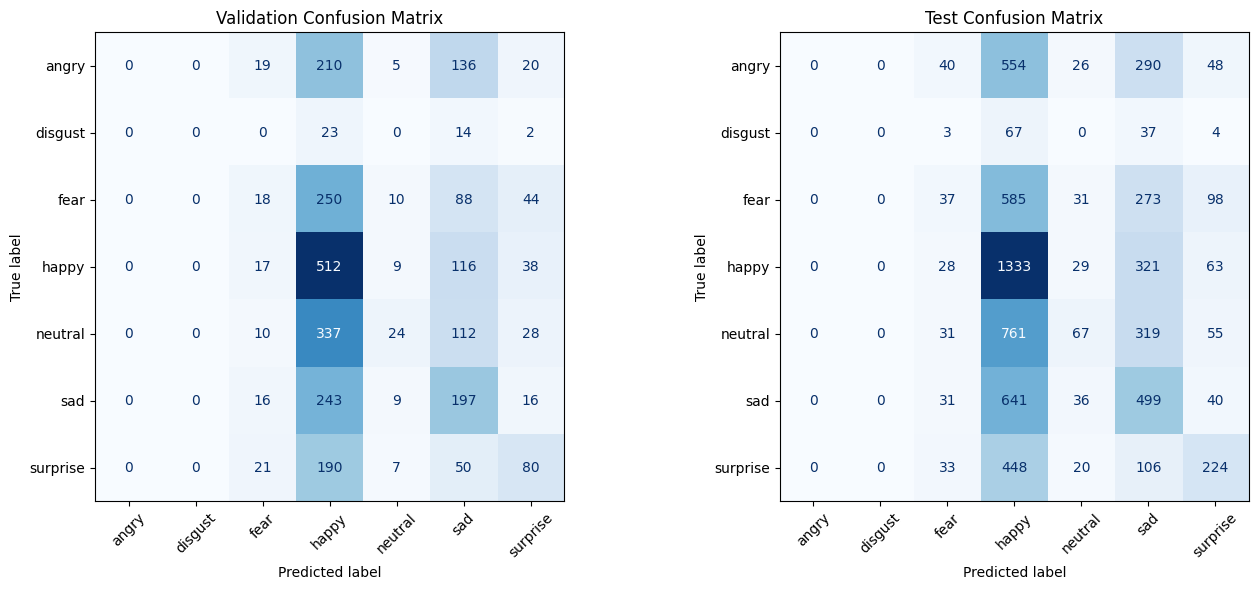

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# get class names from the dataset
class_names = test_loader.dataset.classes

# confusion matrices
cm_val = confusion_matrix(val_labels, val_preds)
cm_test = confusion_matrix(test_labels, test_preds)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Validation cm
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=class_names)
disp_val.plot(ax=axes[0], cmap="Blues", xticks_rotation=45, colorbar=False)
axes[0].set_title("Validation Confusion Matrix")

# Test cm
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)
disp_test.plot(ax=axes[1], cmap="Blues", xticks_rotation=45, colorbar=False)
axes[1].set_title("Test Confusion Matrix")

plt.tight_layout()
plt.show()